In [74]:
import pandas as pd
import numpy as np
import pickle
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn import preprocessing
import patsy

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import patsy

%matplotlib inline
warnings.filterwarnings('ignore')

## Load the Data

In [75]:
stat_types = (['base_stats', 'adv_hitting_stats', 'plate_disc_stats', 'fielding_stats',
               'adv_fielding_stats', 'value_stats', 'win_prob_stats', 'bb_stats'])

In [76]:
def load_data_frame(stat_type):
    filename = 'hitting_' + stat_type + '3.pkl'
    with open(filename, 'rb') as picklefile:
        data = pickle.load(picklefile)
    return data

In [77]:
df_dict = {}
for stat_type in stat_types:
    df = load_data_frame(stat_type)
    df.index.name = 'Player'
    df_dict[stat_type] = df
    print(df_dict[stat_type].shape, stat_type)

(39416, 20) base_stats
(53528, 17) adv_hitting_stats
(34216, 9) plate_disc_stats
(55604, 20) fielding_stats
(40709, 22) adv_fielding_stats
(18444, 12) value_stats
(20928, 10) win_prob_stats
(15642, 14) bb_stats


**Group data by player/season/team**

In [78]:
dfs = []
for k in df_dict.keys():
    df1 = df_dict[k]
    df1 = df1.reset_index().set_index(['Player', 'Season', 'Team'])

    dfs.append(df1)
    
full_df = reduce(lambda left,right: left.join(right), dfs)


In [79]:
first_df = full_df.reset_index().groupby(['Player', 'Season', 'Team']).first()
first_df.shape

(36796, 124)

In [80]:
team_list = (['Blue Jays', 'Orioles', 'Rays', 'Red Sox', 'Yankees', 'Indians', 'Royals', 'Tigers',
        'Twins', 'White Sox', 'Angels', 'Astros', 'Athletics', 'Mariners', 'Rangers', 'Braves',
         'Marlins', 'Mets', 'Nationals', 'Phillies', 'Brewers', 'Cardinals', 'Cubs', 'Pirates',
         'Reds', 'D-backs', 'Dodgers', 'Giants', 'Padres', 'Rockies'])

In [81]:
# Filter out minor league and miscellaneous non-team rows
pro_df = first_df[first_df.index.get_level_values(2).isin(team_list)]

Create columns for the next season, which will serve as our outputs.

In [82]:
pro_df['next_avg'] = pro_df[('base_stats', 'AVG')].groupby(pro_df.index.get_level_values(0)).shift(-1)
pro_df['next_slg'] = pro_df[('adv_hitting_stats', 'SLG')].groupby(pro_df.index.get_level_values(0)).shift(-1)
pro_df['next_ops'] = pro_df[('adv_hitting_stats', 'OPS')].groupby(pro_df.index.get_level_values(0)).shift(-1)
pro_df['next_ab'] = pro_df[('base_stats', 'AB')].groupby(pro_df.index.get_level_values(0)).shift(-1)

In [83]:
pro_df['next_avg'].head(5)

Player      Season  Team   
A.J. Ellis  2008    Dodgers    .100
            2009    Dodgers    .278
            2010    Dodgers    .271
            2011    Dodgers    .270
            2012    Dodgers    .238
Name: next_avg, dtype: object

Find the team the player is on during the season we're predicting.

In [84]:
pro_df['next_team'] = pro_df.index.get_level_values(2)
pro_df['next_team'] = pro_df['next_team'].groupby(pro_df.index.get_level_values(0)).shift(-1)

## Clean and Format the Data

In [85]:
def percent_to_float(column):
    for i in range(column.shape[0]) :
        if column[i] == '\xa0':
            column[i] = np.nan
        #print(pro_df[('bb_stats', 'Hard%')][i])
    #pro_df = pro_df[pd.to_numeric(pro_df.index.get_level_values(1)) > 2001].dropna()
    return column.map(lambda x: float(str(x).strip().replace('%', ''))/100.)

In [86]:
def diff_column(df, column, index_level):
    return column.groupby(df.index.get_level_values(index_level)).diff()

In [87]:
# Filter out pre-2002 when BB_stats began
pro_df = pro_df[pd.to_numeric(pro_df.index.get_level_values(1)) > 2008].dropna()
#pro_df = pro_df[pd.to_numeric(pro_df.index.get_level_values(1)) < 2008].dropna()

In [88]:
pro_df.head(5)

(base_stats, G) (base_stats, AB) (base_stats, PA)  \
Player     Season Team                                                        
A.J. Ellis 2009   Dodgers               8               10               10   
           2010   Dodgers              44              108              128   
           2011   Dodgers              31               85              103   
           2012   Dodgers             133              423              505   
           2013   Dodgers             115              390              448   

                          (base_stats, H) (base_stats, 1B) (base_stats, 2B)  \
Player     Season Team                                                        
A.J. Ellis 2009   Dodgers               1                1                0   
           2010   Dodgers              30               25                5   
           2011   Dodgers              23               19                1   
           2012   Dodgers             114               80               20   
           2013   Dodgers              93               65               17   

                          (base_stats, 3B) (base_stats, HR) (base_stats, R)  \
Player     Season Team                                                        
A.J. Ellis 2009   Dodgers                0                0               0   
           2010   Dodgers                0                0               6   
           2011   Dodgers                1                2               8   
           2012   Dodgers                1               13              44   
           2013   Dodgers                1               10              43   

                          (base_stats, RBI)    ...    (bb_stats, Cent%)  \
Player     Season Team                         ...                        
A.J. Ellis 2009   Dodgers                 1    ...               44.4 %   
           2010   Dodgers                16    ...               44.2 %   
           2011   Dodgers                11    ...               32.9 %   
           2012   Dodgers                52    ...               37.7 %   
           2013   Dodgers                52    ...               40.7 %   

                          (bb_stats, Oppo%) (bb_stats, Soft%)  \
Player     Season Team                                          
A.J. Ellis 2009   Dodgers            22.2 %            33.3 %   
           2010   Dodgers            27.4 %            27.4 %   
           2011   Dodgers            25.7 %            12.9 %   
           2012   Dodgers            30.1 %            14.4 %   
           2013   Dodgers            27.6 %            14.6 %   

                          (bb_stats, Med%) (bb_stats, Hard%) next_avg  \
Player     Season Team                                                  
A.J. Ellis 2009   Dodgers           55.6 %            11.1 %     .278   
           2010   Dodgers           48.4 %            24.2 %     .271   
           2011   Dodgers           58.6 %            28.6 %     .270   
           2012   Dodgers           57.4 %            28.2 %     .238   
           2013   Dodgers           49.7 %            35.7 %     .191   

                          next_slg next_ops next_ab next_team  
Player     Season Team                                         
A.J. Ellis 2009   Dodgers     .324     .687     108   Dodgers  
           2010   Dodgers     .376     .769      85   Dodgers  
           2011   Dodgers     .414     .786     423   Dodgers  
           2012   Dodgers     .364     .682     390   Dodgers  
           2013   Dodgers     .254     .577     283   Dodgers  

[5 rows x 129 columns]

In [89]:
# Conver percent columns to floats
#percent_cols = ['Hard%', 'LD%', 'GB%', 'FB%', 'IFFB%', 'IFH%', 'BUH%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%']
pro_df[('bb_stats', 'Hard%')] = percent_to_float(pro_df[('bb_stats', 'Hard%')])
pro_df.loc[:, ('bb_stats', 'Med%')] = percent_to_float(pro_df[('bb_stats', 'Med%')])
pro_df.loc[:, ('bb_stats', 'LD%')] = percent_to_float(pro_df[('bb_stats', 'LD%')])
pro_df.loc[:, ('bb_stats', 'GB%')] = percent_to_float(pro_df[('bb_stats', 'GB%')])
pro_df.loc[:, ('bb_stats', 'FB%')] = percent_to_float(pro_df[('bb_stats', 'FB%')])
pro_df.loc[:, ('bb_stats', 'IFFB%')] = percent_to_float(pro_df[('bb_stats', 'IFFB%')])
pro_df.loc[:, ('bb_stats', 'IFH%')] = percent_to_float(pro_df[('bb_stats', 'IFH%')])
pro_df.loc[:, ('bb_stats', 'BUH%')] = percent_to_float(pro_df[('bb_stats', 'BUH%')])
pro_df.loc[:, ('bb_stats', 'Pull%')] = percent_to_float(pro_df[('bb_stats', 'Pull%')])
pro_df.loc[:, ('bb_stats', 'Cent%')] = percent_to_float(pro_df[('bb_stats', 'Cent%')])
pro_df.loc[:, ('bb_stats', 'Oppo%')] = percent_to_float(pro_df[('bb_stats', 'Oppo%')])
pro_df.loc[:, ('bb_stats', 'Soft%')] = percent_to_float(pro_df[('bb_stats', 'Soft%')])
pro_df.loc[:, ('bb_stats', 'HR/FB')] = percent_to_float(pro_df[('bb_stats', 'HR/FB')])
pro_df.loc[:, ('adv_hitting_stats', 'K%')] = percent_to_float(pro_df[('adv_hitting_stats', 'K%')])
pro_df.loc[:, ('plate_disc_stats', 'O-Swing%')] = percent_to_float(pro_df[('plate_disc_stats', 'O-Swing%')])
pro_df.loc[:, ('plate_disc_stats', 'Z-Swing%')] = percent_to_float(pro_df[('plate_disc_stats', 'Z-Swing%')])
pro_df.loc[:, ('plate_disc_stats', 'Swing%')] = percent_to_float(pro_df[('plate_disc_stats', 'Swing%')])
pro_df.loc[:, ('plate_disc_stats', 'O-Contact%')] = percent_to_float(pro_df[('plate_disc_stats', 'O-Contact%')])
pro_df.loc[:, ('plate_disc_stats', 'Z-Contact%')] = percent_to_float(pro_df[('plate_disc_stats', 'Z-Contact%')])
pro_df.loc[:, ('plate_disc_stats', 'Zone%')] = percent_to_float(pro_df[('plate_disc_stats', 'Zone%')])
pro_df.loc[:, ('plate_disc_stats', 'Contact%')] = percent_to_float(pro_df[('plate_disc_stats', 'Contact%')])
pro_df.loc[:, ('plate_disc_stats', 'F-Strike%')] = percent_to_float(pro_df[('plate_disc_stats', 'F-Strike%')])
pro_df.loc[:, ('plate_disc_stats', 'SwStr%')] = percent_to_float(pro_df[('plate_disc_stats', 'SwStr%')])


In [90]:
pro_df.shape

(4268, 129)

In [325]:
# Filter by At bats greater than 350
filtered_abs = pro_df[pd.to_numeric(first_df[('base_stats', 'AB')]) > 350]
filtered_abs = filtered_abs[pd.to_numeric(pro_df['next_ab']) > 350]

In [326]:
filtered_abs.shape

(890, 129)

In [327]:
# Do not include Total rows
filtered_abs = filtered_abs[filtered_abs.index.get_level_values(1) != 'Total']

In [328]:
# Drop Adam Eaton and Chris Young because their data was messed up
filtered_abs = filtered_abs[filtered_abs.index.get_level_values(0) != 'Adam Eaton']
filtered_abs = filtered_abs[filtered_abs.index.get_level_values(0) != 'Chris Young']


In [329]:
filtered_abs_post_2001 = filtered_abs

In [330]:
filtered_abs_post_2001[('bb_stats', 'Hard_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Hard%')], 0)
filtered_abs_post_2001[('bb_stats', 'Med_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Med%')], 0)
filtered_abs_post_2001[('bb_stats', 'LD_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'LD%')], 0)
filtered_abs_post_2001[('bb_stats', 'GB_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'GB%')], 0)
filtered_abs_post_2001[('bb_stats', 'FB_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'FB%')], 0)
filtered_abs_post_2001[('bb_stats', 'IFFB_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'IFFB%')], 0)
filtered_abs_post_2001[('bb_stats', 'IFH_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'IFH%')], 0)
filtered_abs_post_2001[('bb_stats', 'BUH_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'BUH%')], 0)
filtered_abs_post_2001[('bb_stats', 'Pull_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Pull%')], 0)
filtered_abs_post_2001[('bb_stats', 'Cent_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Cent%')], 0)
filtered_abs_post_2001[('bb_stats', 'Oppo_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Oppo%')], 0)
filtered_abs_post_2001[('bb_stats', 'Soft_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'Soft%')], 0)
filtered_abs_post_2001[('bb_stats', 'HR/FB_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('bb_stats', 'HR/FB')], 0)
filtered_abs_post_2001[('adv_hitting_stats', 'K_per_diff')] = diff_column(filtered_abs_post_2001, filtered_abs_post_2001[('adv_hitting_stats', 'K%')], 0)
filtered_abs_post_2001[('base_stats', 'avg_diff')] = diff_column(filtered_abs_post_2001, (filtered_abs_post_2001[('base_stats', 'AVG')]).astype(float), 0)


In [331]:
filtered_abs_post_2001['next_avg'].head(5)

Player           Season  Team     
A.J. Ellis       2012    Dodgers      .238
A.J. Pierzynski  2009    White Sox    .270
                 2010    White Sox    .287
                 2011    White Sox    .278
                 2012    White Sox    .272
Name: next_avg, dtype: object

In [332]:
for c in filtered_abs_post_2001.columns:
    if c[0:4] != 'next':
        filtered_abs_post_2001 = filtered_abs_post_2001.rename(columns={c: str(c[0] + '_' + c[1])})

## Try Out Some Engineered Features

In [333]:
filtered_abs_post_2001['extreme_pull'] = (filtered_abs_post_2001['bb_stats_Pull%'] > .45).astype(float)

In [334]:
filtered_abs_post_2001['sprayer'] = (abs(filtered_abs_post_2001['bb_stats_Pull%'] - filtered_abs_post_2001['bb_stats_Oppo%']) < .1).astype(float)

In [335]:
filtered_abs_post_2001['hh_contact'] = filtered_abs_post_2001['bb_stats_Hard%'] * filtered_abs_post_2001['plate_disc_stats_Contact%']

In [336]:
filtered_abs_post_2001['fb%_hr/fb'] = filtered_abs_post_2001['bb_stats_FB%'] * filtered_abs_post_2001['bb_stats_HR/FB']

In [337]:
filtered_abs_post_2001['hard_med'] = (2 * filtered_abs_post_2001['bb_stats_Hard%']) + (.5 * filtered_abs_post_2001['bb_stats_Med%'])

In [338]:
filtered_abs_post_2001['extreme_high_soft'] = (filtered_abs_post_2001['bb_stats_Soft%'] > .25).astype(float)

In [339]:
filtered_abs_post_2001['extreme_ifh'] = (filtered_abs_post_2001['bb_stats_IFH%'] > .105).astype(float)

In [340]:
filtered_abs_post_2001['extreme_low_soft'] = (filtered_abs_post_2001['bb_stats_Soft%'] < .135).astype(float)

In [341]:
#filtered_abs_post_2001['swing_med'] = (2 * filtered_abs_post_2001['bb_stats_Hard%']) + (.5 * filtered_abs_post_2001['bb_stats_Med%'])

In [342]:
filtered_abs_post_2001['hh_contact_swing'] = filtered_abs_post_2001['bb_stats_Hard%'] * filtered_abs_post_2001['plate_disc_stats_Contact%'] * filtered_abs_post_2001['plate_disc_stats_Swing%'] 

In [343]:
filtered_abs_post_2001['hard_med_contact_swing'] = filtered_abs_post_2001['hard_med'] * filtered_abs_post_2001['plate_disc_stats_Contact%'] * filtered_abs_post_2001['plate_disc_stats_Swing%'] 

In [344]:
filtered_abs_post_2001['hh_babip'] = filtered_abs_post_2001['bb_stats_Hard%'] / filtered_abs_post_2001['adv_hitting_stats_BABIP'].astype('float')

In [345]:
filtered_abs_post_2001['pull_fb'] = filtered_abs_post_2001['bb_stats_Pull%'] / filtered_abs_post_2001['bb_stats_FB%'].astype('float')

In [346]:
filtered_abs_post_2001['hard_ld'] = filtered_abs_post_2001['bb_stats_Hard%'] / filtered_abs_post_2001['bb_stats_LD%'].astype('float')

In [347]:
feature_cols = (['adv_hitting_stats_K%', 'bb_stats_LD%', 'bb_stats_FB%', 'bb_stats_GB/FB', 'bb_stats_IFFB%', 'bb_stats_HR/FB',
                 'bb_stats_IFH%', 'bb_stats_Cent%', 'bb_stats_Oppo%', 'bb_stats_Soft%', 'bb_stats_Hard%', 
                 'bb_stats_Hard_diff', 'plate_disc_stats_Swing%', 'bb_stats_Pull%',
                 'plate_disc_stats_O-Contact%', 'plate_disc_stats_Z-Contact%',
                 'plate_disc_stats_Zone%', 'adv_hitting_stats_Spd', 'extreme_pull', 
                 'sprayer', 'hh_contact', 'fb%_hr/fb', 'hard_med', 'extreme_low_soft', 'extreme_high_soft',
                 'extreme_ifh', 'hh_contact_swing', 'hard_med_contact_swing', 'hh_babip', 'pull_fb', 'hard_ld'])

In [368]:
clean = filtered_abs_post_2001.dropna()

In [369]:
base = clean.loc[:, []]

In [370]:
# The baseline value we are trying to beat
X_baseline = clean['base_stats_AVG']
X_baseline;

In [372]:
# The output
y = clean.loc[:, 'next_avg']
y = y.astype('float')
y.shape

(570,)

In [352]:
def find_best_predictor(current, predictors, y):
    best_p = 0
    model_ps = []
    while best_p < .005:
        p = []
        curr_cols = ['next_team']
        for pred in predictors:
            cols = curr_cols[:]
            cols.append(pred)
            X = clean.loc[:, cols]
            #X.iloc[:, 1:] = X.iloc[:, 1:].astype('float')
            team = patsy.dmatrix('next_team',
                             data=X,
                             return_type='dataframe')
            X.drop(['next_team'], axis=1, inplace=True)
            X = X.astype('float')
            X = X.join(team)
            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2)
            est2 = est.fit()
            p.append((pred, est2.pvalues[0]))
        ps = sorted(p, key=lambda x: x[1])
        print(ps[0])
        best_p = ps[0][1]
        if best_p < .005:
            curr_cols.append(ps[0][0])
            model_ps.append(ps[0][0])
            predictors.pop(predictors.index(ps[0][0]))
    return model_ps

In [353]:
best_cols = find_best_predictor([], feature_cols, y)

('adv_hitting_stats_K%', 9.8065391499412859e-20)
('plate_disc_stats_O-Contact%', 5.4209624024068604e-15)
('plate_disc_stats_Z-Contact%', 6.2473202543327559e-13)
('bb_stats_Pull%', 7.3046661515408208e-13)
('bb_stats_FB%', 7.3841587832054108e-12)
('extreme_pull', 1.2593275600410226e-11)
('bb_stats_Oppo%', 1.8100945541499313e-09)
('bb_stats_GB/FB', 1.4909286350876595e-07)
('bb_stats_Cent%', 1.980239699910894e-07)
('hard_med_contact_swing', 4.6715349760684683e-07)
('bb_stats_IFFB%', 3.1686365762722556e-06)
('fb%_hr/fb', 1.9620628974535563e-05)
('hh_babip', 0.00026689259666065862)
('bb_stats_LD%', 0.00060763721748065117)
('sprayer', 0.0009292119200967245)
('hh_contact_swing', 0.0022842946119204194)
('hard_ld', 0.0024677048143271537)
('hh_contact', 0.029280208751018288)


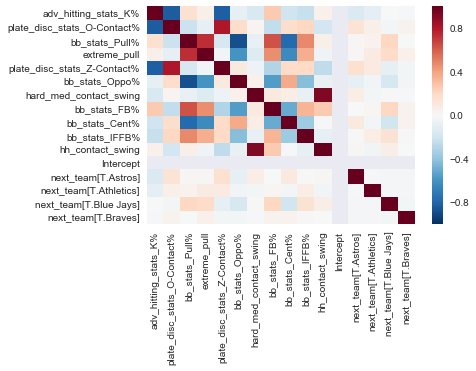

In [354]:
sns.heatmap(X.iloc[:, :len(best_cols)].corr())


In [355]:
best_cols.append('next_team')

In [356]:
X = clean.loc[:, best_cols]

In [357]:
team = patsy.dmatrix('next_team',
                     data=X,
                     return_type='dataframe')

In [358]:
X.drop(['next_team'], axis=1, inplace=True)

X = X.join(team)

[ -1.58588179e-01   2.51607501e-02   7.97245297e-02  -9.69442697e-01
  -7.39405912e-02  -8.51692727e-03  -8.39102000e-01  -6.17608746e-03
  -9.65675299e-01  -4.36378469e-01  -1.39746981e-01   2.16727559e-01
  -2.32842448e-02  -2.19539728e-01  -1.08684278e-02   1.33448804e+00
  -2.16684616e-02  -2.81913382e-13   1.85297139e-02  -1.66025157e-02
  -3.31998156e-03  -9.48827610e-03   6.38966096e-03   2.78170579e-03
  -1.04878447e-02   2.51253045e-03   6.47630438e-03  -4.82326780e-03
  -7.66319770e-03  -2.30209987e-04   4.14876357e-03   9.36097055e-05
  -8.27345102e-03  -1.26085984e-02  -2.93221804e-03  -1.58410088e-03
  -2.13329521e-03  -1.45778599e-02   2.36610600e-03  -1.48413769e-03
   2.14762753e-02  -4.67276203e-03   2.08936554e-02  -9.20338695e-03
  -4.05655465e-03  -5.63471010e-03]
0.382743127958


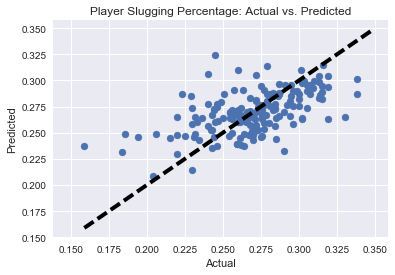

In [359]:
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)


#print(actual)
print(lr.coef_)
print(lr.score(X,y))
# plt.scatter(y_test.reset_index()['value_stats_WAR'].tolist(), (lr.predict(X_test)))
# plt.scatter(y_test.reset_index()['base_stats_AVG'].tolist(), (lr.predict(X_test)))
# plt.scatter(y_test.reset_index()['adv_hitting_stats_SLG'].tolist(), (lr.predict(X_test)))
plt.scatter(y_test.reset_index()['next_avg'].tolist(), (lr.predict(X_test)))

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Player Slugging Percentage: Actual vs. Predicted')
#plt.scatter(X_test[X_test.columns[[3]]], y_test)
#print(pd.DataFrame(y).join(lr.predict(y)))

In [360]:
#print(X)
Results = pd.DataFrame(X).copy()
pred = lr.predict(X)
#print((pred))
#print(pd.DataFrame(Results))
Results['prev'] = filtered_abs_post_2001['base_stats_AVG'].astype('float')
Results['pred'] = pred
Results['actual'] = y
Results['base_diff'] = Results['prev'] - Results['actual']
Results['diff'] = Results['pred'] - Results['actual']
print(Results.loc[:, 'prev' : 'diff'].sort_values(by='diff'))


                                     prev      pred  actual  base_diff  \
Player            Season Team                                            
Bryce Harper      2014   Nationals  0.273  0.264805   0.330     -0.057   
Mike Napoli       2010   Angels     0.238  0.255156   0.320     -0.082   
Russell Martin    2013   Pirates    0.226  0.232617   0.290     -0.064   
Freddie Freeman   2012   Braves     0.259  0.263206   0.319     -0.060   
Andrew McCutchen  2011   Pirates    0.259  0.271798   0.327     -0.068   
Matt Kemp         2010   Dodgers    0.249  0.269735   0.324     -0.075   
Michael Brantley  2013   Indians    0.284  0.274905   0.327     -0.043   
Michael Young     2010   Rangers    0.284  0.286165   0.338     -0.054   
Adrian Gonzalez   2010   Padres     0.298  0.286775   0.338     -0.040   
Carlos Ruiz       2011   Phillies   0.283  0.275431   0.325     -0.042   
Brian Dozier      2015   Twins      0.236  0.220218   0.268     -0.032   
Joey Votto        2011   Reds       0.

0.420736359019


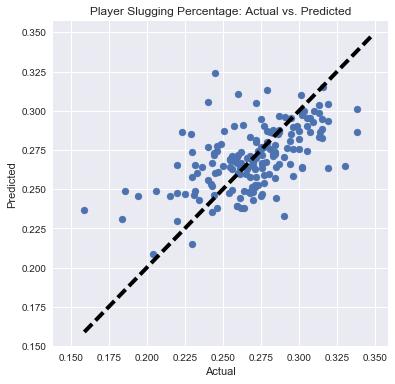

In [361]:
from sklearn.linear_model import RidgeCV
rcv = RidgeCV(cv=5)
rcv.fit(X, y)
print(rcv.score(X_test, y_test))
ridge_coeffs = rcv.coef_

plt.figure(figsize=(6,6))
plt.scatter(y_test.reset_index()['next_avg'].tolist(), (lr.predict(X_test)))

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Player Slugging Percentage: Actual vs. Predicted')

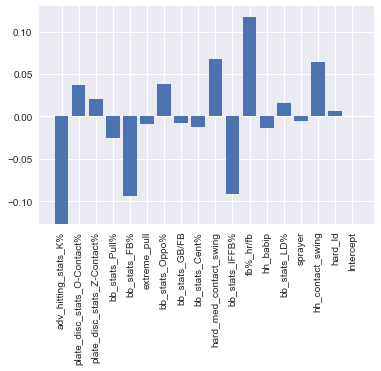

In [362]:
fig,ax = plt.subplots()
ax.bar(range(len(ridge_coeffs[0:len(best_cols)])), ridge_coeffs[0:len(best_cols)])
ax.set_xticklabels(list(X.columns)[0:len(best_cols)], rotation=90)
ax.xaxis.set_ticks(range(len(best_cols)))


In [373]:
ResultsRCV = pd.DataFrame(X).copy()
pred = rcv.predict(X)
#print((pred))
#print(pd.DataFrame(Results))
ResultsRCV['prev'] = filtered_abs_post_2001['base_stats_AVG'].astype('float')
ResultsRCV['pred'] = pred
ResultsRCV['actual'] = y
ResultsRCV['base_diff'] = ResultsRCV['prev'] - ResultsRCV['actual']

ResultsRCV['diff'] = ResultsRCV['pred'] - ResultsRCV['actual']
print(ResultsRCV.loc[:, 'pred' : 'diff'].sort_values(by='diff'))
print('Model MSE: ' + str(sum(ResultsRCV['diff'] * ResultsRCV['diff'])/ResultsRCV['diff'].shape[0]))
print('Copy MSE: ' + str(sum(ResultsRCV['base_diff'] * ResultsRCV['base_diff'])/ResultsRCV['base_diff'].shape[0]))


                                         pred  actual  base_diff      diff
Player             Season Team                                            
Bryce Harper       2014   Nationals  0.267660   0.330     -0.057 -0.062340
Mike Napoli        2010   Angels     0.259189   0.320     -0.082 -0.060811
Andrew McCutchen   2011   Pirates    0.267497   0.327     -0.068 -0.059503
Melky Cabrera      2011   Royals     0.289373   0.346     -0.041 -0.056627
Matt Kemp          2010   Dodgers    0.268670   0.324     -0.075 -0.055330
Alex Rios          2011   White Sox  0.249388   0.304     -0.077 -0.054612
Carlos Ruiz        2011   Phillies   0.272757   0.325     -0.042 -0.052243
Joey Votto         2011   Reds       0.285438   0.337     -0.028 -0.051562
Torii Hunter       2011   Angels     0.262343   0.313     -0.051 -0.050657
Michael Brantley   2013   Indians    0.276844   0.327     -0.043 -0.050156
Freddie Freeman    2012   Braves     0.269356   0.319     -0.060 -0.049644
Adrian Gonzalez    2010  

In [374]:
from sklearn.linear_model import ElasticNetCV
encv = ElasticNetCV(cv=5)
encv.fit(X, y)
encv.score(X_test, y_test)

0.4281113726655576

In [375]:
from sklearn.linear_model import LassoCV
lcv = LassoCV(cv=5)
lcv.fit(X, y)
lcv.score(X_test, y_test)

0.42856917853841681